# If you want to access the version you have already modified, click "Edit"
# If you want to access the original sample code, click "...", then click "Copy & Edit Notebook"

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu117
True


In [2]:
import cv2

In [3]:
torch.cuda.set_device(2)

In [4]:
_exp_name = "pre_semi_spin"
number_class=101
a_style='all spins'
a_type_1='all spins'
a_type_2='a+0.94_shi'

In [5]:
# Import necessary packages.
import numpy as np
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [6]:
myseed = 1215  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


## **Datasets_part1**
讀取影像成為資料

In [8]:

import os
import re

#INTER_LINEAR – a bilinear interpolation (used by default)

def RHdataset(root_dir):
    Rh_data = []
    IMG_SIZE = 224
    labels = []
    
    for filename in os.listdir(root_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # 組合完整的檔案路徑
            file_path = os.path.join(root_dir, filename)

            # 讀取照片
            img = cv2.imread(file_path)

            # 確保成功讀取照片
            if img is not None:
                # 將照片 resize 到指定的尺寸
                resized_img = cv2.resize(img, (224, 224),interpolation=cv2.INTER_LINEAR)
                #resized_img=resized_img/255
                #resized_img[0] = (resized_img[0]-0.485)/0.229
                #resized_img[1] = (resized_img[1]-0.456)/0.224
                #resized_img[2] = (resized_img[2]-0.406)/0.225
                
                # 將 resize 後的照片加入列表
                Rh_data.append(resized_img)
            else:
                print(f"無法讀取照片: {file_path}")
                
    for filename in os.listdir(root_dir):
        # 使用正則表達式匹配檔案名稱中的數字部分，並轉換為浮點數
        match = re.search(r'a([\d.]+)_', filename)
        if match:
            label = float(match.group(1))
            label=label*100
            labels.append(label)

    
    return Rh_data, labels


In [9]:
import os
import cv2
import numpy as np
import random

#num_samples=200

def MADdataset(root_dir, label_num):
    
    Rh_data = []
    IMG_SIZE = 224

    for label_folder in os.listdir(root_dir):
        if not label_folder.startswith('.'):
            label_path = os.path.join(root_dir, label_folder)
            
            img = cv2.imread(label_path)
            
            if img is not None:
                # 將照片 resize 到指定的尺寸
                resized_img = cv2.resize(img, (224, 224),interpolation=cv2.INTER_LINEAR)
                #resized_img=resized_img/255
                #resized_img[0] = (resized_img[0]-0.485)/0.229
                #resized_img[1] = (resized_img[1]-0.456)/0.224
                #resized_img[2] = (resized_img[2]-0.406)/0.225
                
                # 將 resize 後的照片加入列表
                Rh_data.append(resized_img)
            else:
                print(f"無法讀取照片: {label_path}")

    Rh_label = np.ones(len(Rh_data), dtype=int) * label_num
    
    return Rh_data, Rh_label


In [10]:

u94_Rh1_data,u94_Rh1_label = RHdataset(root_dir="semi_anlayic/raif_img")
print('all are ok')


all are ok


In [11]:

u94_Rh160_data,u94_Rh160_label=MADdataset(root_dir="mean_MAD/10_a_plus_short30/a0",label_num=0)
d94_Rh1_data,d94_Rh1_label = MADdataset(root_dir="mean_MAD/10_a_plus_short30/a0.5",label_num=50)
d94_Rh10_data,d94_Rh10_label=MADdataset(root_dir="mean_MAD/10_a_plus_short30/a0.94",label_num=94)

print('all are ok')

all are ok


In [36]:
#print(d94_Rh1_data,d94_Rh1_label)

In [13]:
'''
d94_Rh80_data,d94_Rh80_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh80",label_num=25)
d94_Rh160_data,d94_Rh160_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh160",label_num=33)
'''

'\nd94_Rh80_data,d94_Rh80_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh80",label_num=25)\nd94_Rh160_data,d94_Rh160_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh160",label_num=33)\n'

In [12]:
print(len(u94_Rh1_data))

2550


In [13]:
print(min(u94_Rh1_label))

0.0


In [14]:
batch_size=16

In [17]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# torch.nn.MaxPool2d(kernel_size, stride, padding)
# input 維度 [128,128,3]

In [15]:
import torchvision.models as models
# 載入預先訓練的 ResNet-18 模型
device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.
model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, number_class)

model = model.to(device)
# 定義 MSE loss
criterion = nn.MSELoss()

#weight_decay=1e-7
# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4,weight_decay=5e-6)

/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## **Datasets_part2**
組合資料變成資料集

In [17]:

train_data=np.array(u94_Rh1_data)
label=np.array(u94_Rh1_label)
#,d94_Rh20_data,d94_Rh40_data,d94_Rh80_data,d94_Rh160_data,u94_Rh10_data,u94_Rh20_data,u94_Rh40_data,u94_Rh80_data,
#,d94_Rh20_label,d94_Rh40_label,d94_Rh80_label,d94_Rh160_label,u94_Rh10_label,u94_Rh20_label,u94_Rh40_label,u94_Rh80_label,
data_targets=[u94_Rh160_data,d94_Rh1_data,d94_Rh10_data
             ]
data_labels=[u94_Rh160_label,d94_Rh1_label,d94_Rh10_label
            ]
for i in data_targets:
    gg=np.array(i)
    train_data=np.append(train_data,gg,axis=0)

for i in data_labels:
    jj=np.array(i)
    label=np.append(label,jj)


In [ ]:
#train_data=np.array(u94_Rh1_data)
#label=np.array(u94_Rh1_label)

In [18]:
class RhDataset(Dataset):
    def __init__(self):
        self.x=train_data
        self.y=label

    def __getitem__(self, idx):
        
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [19]:
batch_size=32
train_set = RhDataset()

In [20]:
train_data_point, label_0 = train_set[101]
print(label_0)

54.0


In [21]:
print(len(train_data))
n_total = len(train_data)
n_train = int(0.6 * n_total)
n_valid = int(0.2* n_total)
n_test = n_total - n_train -n_valid
train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(train_set, [n_train,n_valid, n_test])


2580


In [22]:
tt,tl=train_dataset[0]
print(len(train_dataset))

1548


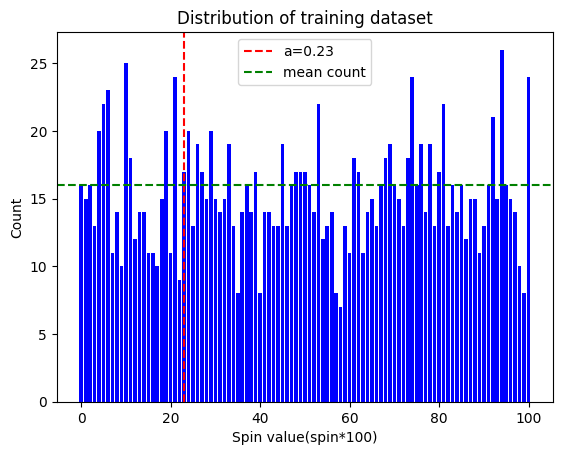

In [43]:
N_label=[]
for i in range(len(train_dataset)):
    tt,tl=train_dataset[i]
    N_label.append(tl)
    
import matplotlib.pyplot as plt


# 計算各數字的數量
counts = {num: N_label.count(num) for num in set(N_label)}

# 繪製直方圖
plt.bar(counts.keys(), counts.values(), color='blue')

# 在 x=5 的地方畫垂直線
plt.axvline(x=23.0, color='red', linestyle='--', label='a=0.23')

# 在 y=3 的地方畫水平線
plt.axhline(y=16, color='green', linestyle='--', label='mean count')

# 加上標籤和標題
plt.xlabel('Spin value(spin*100)')
plt.ylabel('Count')
plt.title('Distribution of training dataset')
plt.legend()

# 顯示圖形
plt.show()


In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

In [24]:
len(test_dataset)

516

## **訓練資料**

In [46]:
#1-160把1當成0，每10一分類，就有17類

n_epochs=500

patience = 40 
stale = 0
best_acc = 0

tra_loss=[]
val_loss=[]


for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    for images, labels in tqdm(train_loader):
        # 正向傳播
        images= images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        labels=labels.long()
        images=images.float()
        outputs = model(images)
        loss = criterion(outputs, torch.nn.functional.one_hot(labels, number_class).float())  # 使用 one-hot 編碼

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    tra_loss.append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    for images, labels in tqdm(valid_loader):
        # 正向傳播
        images= images.permute(0, 3, 1, 2)
        images=images.float()
        images, labels = images.to(device), labels.to(device)
        labels=labels.long()
        with torch.no_grad():
            outputs = model(images).to(device)
        loss = criterion(outputs, torch.nn.functional.one_hot(labels, number_class).float())  # 使用 one-hot 編碼

        
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    val_loss.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_{myseed}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
print('訓練完成')

  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 0.02583, acc = 0.02296


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 0.01065, acc = 0.03309
Best model found at epoch 0, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 0.01043, acc = 0.03827


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 0.01081, acc = 0.01287


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 0.01047, acc = 0.04273


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 0.01043, acc = 0.01838


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 0.01036, acc = 0.07122


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 0.01070, acc = 0.05147
Best model found at epoch 3, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 0.01023, acc = 0.09141


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 0.01059, acc = 0.08824
Best model found at epoch 4, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 0.01011, acc = 0.13308


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 0.01018, acc = 0.12316
Best model found at epoch 5, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 0.00994, acc = 0.17560


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 0.01010, acc = 0.17647
Best model found at epoch 6, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 0.00975, acc = 0.22640


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 0.01058, acc = 0.12868


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 0.00939, acc = 0.28997


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 0.01024, acc = 0.26103
Best model found at epoch 8, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 0.00901, acc = 0.39349


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 0.00944, acc = 0.33272
Best model found at epoch 9, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 0.00846, acc = 0.45514


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 0.00977, acc = 0.35294
Best model found at epoch 10, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 0.00822, acc = 0.51786


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 0.01034, acc = 0.32904


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 0.00756, acc = 0.55421


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 0.00958, acc = 0.30882


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 0.00721, acc = 0.59418


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 0.00834, acc = 0.50184
Best model found at epoch 13, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 0.00674, acc = 0.64201


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 0.00788, acc = 0.56618
Best model found at epoch 14, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 0.00642, acc = 0.67708


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 0.00868, acc = 0.44118


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 0.00621, acc = 0.68197


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 0.00775, acc = 0.54596


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 0.00583, acc = 0.70706


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 0.00632, acc = 0.65257
Best model found at epoch 17, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 0.00559, acc = 0.72640


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 0.00649, acc = 0.66912
Best model found at epoch 18, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 0.00529, acc = 0.74469


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 0.00674, acc = 0.63051


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 0.00498, acc = 0.77806


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 0.00641, acc = 0.62684


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 0.00502, acc = 0.75957


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 0.00752, acc = 0.55331


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 0.00481, acc = 0.78040


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 0.00607, acc = 0.69669
Best model found at epoch 22, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 0.00454, acc = 0.79826


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 0.00610, acc = 0.63419


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 0.00446, acc = 0.79124


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 0.00605, acc = 0.67463


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 0.00433, acc = 0.79315


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 0.00615, acc = 0.67279


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 0.00422, acc = 0.79953


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 0.00600, acc = 0.66544


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 0.00421, acc = 0.83057


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 0.00515, acc = 0.74816
Best model found at epoch 27, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 0.00395, acc = 0.82866


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 0.00546, acc = 0.69118


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 0.00379, acc = 0.83185


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 0.00494, acc = 0.69301


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 0.00355, acc = 0.85034


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 0.00469, acc = 0.75368
Best model found at epoch 30, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 0.00369, acc = 0.82504


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 0.00583, acc = 0.63419


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 0.00340, acc = 0.86012


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 0.00483, acc = 0.72059


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 0.00355, acc = 0.85204


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 0.00533, acc = 0.70956


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 0.00356, acc = 0.84524


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 0.00522, acc = 0.68015


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 0.00310, acc = 0.87181


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 0.00484, acc = 0.70404


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 0.00329, acc = 0.86841


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 0.00496, acc = 0.72978


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 0.00290, acc = 0.87883


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 0.00530, acc = 0.69853


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 0.00293, acc = 0.88329


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 0.00499, acc = 0.70404


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 0.00299, acc = 0.88520


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 0.00479, acc = 0.74081


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 0.00273, acc = 0.89052


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 0.00490, acc = 0.72610


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 0.00258, acc = 0.91029


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 0.00481, acc = 0.70956


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 0.00238, acc = 0.91475


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 0.00519, acc = 0.71875


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 0.00252, acc = 0.90986


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 0.00484, acc = 0.74449


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 0.00254, acc = 0.91029


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 0.00497, acc = 0.72243


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 0.00184, acc = 0.95026


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 0.00507, acc = 0.73346


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 0.00176, acc = 0.95408


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 0.00432, acc = 0.74449


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 0.00165, acc = 0.95940


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 0.00448, acc = 0.73713


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 0.00165, acc = 0.95599


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 0.00422, acc = 0.73346


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 0.00128, acc = 0.98087


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 0.00415, acc = 0.74632


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 0.00138, acc = 0.96939


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 0.00442, acc = 0.74449


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 0.00101, acc = 0.98980


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 0.00393, acc = 0.77941
Best model found at epoch 51, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 0.00134, acc = 0.96875


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 0.00463, acc = 0.73529


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 0.00161, acc = 0.95748


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 0.00403, acc = 0.78676
Best model found at epoch 53, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 0.00127, acc = 0.97959


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 0.00401, acc = 0.78125


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 0.00110, acc = 0.98023


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 0.00392, acc = 0.78493


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 0.00120, acc = 0.97832


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 0.00401, acc = 0.78676


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 0.00125, acc = 0.97640


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 0.00445, acc = 0.77390


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 0.00094, acc = 0.99235


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 0.00390, acc = 0.75184


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 0.00092, acc = 0.99298


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 0.00389, acc = 0.76654


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 0.00072, acc = 0.99554


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 0.00368, acc = 0.77574


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 0.00107, acc = 0.98469


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 0.00493, acc = 0.70956


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 0.00142, acc = 0.97385


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 0.00477, acc = 0.72426


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 0.00113, acc = 0.98724


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 0.00406, acc = 0.74816


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 0.00106, acc = 0.98278


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 0.00451, acc = 0.74265


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 066/500 ] loss = 0.00093, acc = 0.99171


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 066/500 ] loss = 0.00405, acc = 0.75919


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 067/500 ] loss = 0.00093, acc = 0.98724


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 067/500 ] loss = 0.00373, acc = 0.79779
Best model found at epoch 66, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 068/500 ] loss = 0.00158, acc = 0.95791


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 068/500 ] loss = 0.00500, acc = 0.71875


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 069/500 ] loss = 0.00164, acc = 0.95621


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 069/500 ] loss = 0.00452, acc = 0.74081


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 070/500 ] loss = 0.00155, acc = 0.96832


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 070/500 ] loss = 0.00503, acc = 0.72794


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 071/500 ] loss = 0.00156, acc = 0.96365


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 071/500 ] loss = 0.00432, acc = 0.75184


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 072/500 ] loss = 0.00115, acc = 0.97895


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 072/500 ] loss = 0.00427, acc = 0.75551


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 073/500 ] loss = 0.00109, acc = 0.98023


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 073/500 ] loss = 0.00469, acc = 0.70221


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 074/500 ] loss = 0.00115, acc = 0.98023


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 074/500 ] loss = 0.00507, acc = 0.71875


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 075/500 ] loss = 0.00140, acc = 0.96875


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 075/500 ] loss = 0.00496, acc = 0.69118


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 076/500 ] loss = 0.00104, acc = 0.98214


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 076/500 ] loss = 0.00416, acc = 0.74632


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 077/500 ] loss = 0.00100, acc = 0.98151


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 077/500 ] loss = 0.00400, acc = 0.77390


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 078/500 ] loss = 0.00077, acc = 0.99107


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 078/500 ] loss = 0.00370, acc = 0.79044


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 079/500 ] loss = 0.00071, acc = 0.99362


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 079/500 ] loss = 0.00362, acc = 0.77757


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 080/500 ] loss = 0.00090, acc = 0.98214


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 080/500 ] loss = 0.00423, acc = 0.75735


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 081/500 ] loss = 0.00084, acc = 0.98916


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 081/500 ] loss = 0.00407, acc = 0.76654


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 082/500 ] loss = 0.00075, acc = 0.98980


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 082/500 ] loss = 0.00448, acc = 0.72978


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 083/500 ] loss = 0.00117, acc = 0.97449


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 083/500 ] loss = 0.00493, acc = 0.71507


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 084/500 ] loss = 0.00122, acc = 0.97343


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 084/500 ] loss = 0.00408, acc = 0.75551


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 085/500 ] loss = 0.00114, acc = 0.98214


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 085/500 ] loss = 0.00452, acc = 0.73713


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 086/500 ] loss = 0.00109, acc = 0.98023


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 086/500 ] loss = 0.00441, acc = 0.75919


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 087/500 ] loss = 0.00095, acc = 0.98278


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 087/500 ] loss = 0.00436, acc = 0.72978


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 088/500 ] loss = 0.00098, acc = 0.98788


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 088/500 ] loss = 0.00502, acc = 0.69301


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 089/500 ] loss = 0.00086, acc = 0.98980


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 089/500 ] loss = 0.00372, acc = 0.76654


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 090/500 ] loss = 0.00089, acc = 0.98469


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 090/500 ] loss = 0.00405, acc = 0.75000


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 091/500 ] loss = 0.00074, acc = 0.99107


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 091/500 ] loss = 0.00372, acc = 0.77390


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 092/500 ] loss = 0.00055, acc = 0.99681


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 092/500 ] loss = 0.00373, acc = 0.76471


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 093/500 ] loss = 0.00047, acc = 0.99617


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 093/500 ] loss = 0.00353, acc = 0.78493


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 094/500 ] loss = 0.00044, acc = 0.99554


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 094/500 ] loss = 0.00402, acc = 0.73713


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 095/500 ] loss = 0.00043, acc = 0.99745


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 095/500 ] loss = 0.00332, acc = 0.81618
Best model found at epoch 94, saving model


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 096/500 ] loss = 0.00057, acc = 0.99298


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 096/500 ] loss = 0.00469, acc = 0.71324


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 097/500 ] loss = 0.00129, acc = 0.96259


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 097/500 ] loss = 0.00462, acc = 0.77390


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 098/500 ] loss = 0.00196, acc = 0.93580


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 098/500 ] loss = 0.00705, acc = 0.61765


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 099/500 ] loss = 0.00284, acc = 0.90327


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 099/500 ] loss = 0.00563, acc = 0.69485


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 100/500 ] loss = 0.00171, acc = 0.96046


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 100/500 ] loss = 0.00455, acc = 0.73897


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 101/500 ] loss = 0.00097, acc = 0.98427


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 101/500 ] loss = 0.00422, acc = 0.74632


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 102/500 ] loss = 0.00103, acc = 0.97321


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 102/500 ] loss = 0.00456, acc = 0.72610


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 103/500 ] loss = 0.00073, acc = 0.98980


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 103/500 ] loss = 0.00398, acc = 0.76287


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 104/500 ] loss = 0.00058, acc = 0.99298


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 104/500 ] loss = 0.00399, acc = 0.76103


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 105/500 ] loss = 0.00061, acc = 0.99362


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 105/500 ] loss = 0.00423, acc = 0.75919


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 106/500 ] loss = 0.00071, acc = 0.98661


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 106/500 ] loss = 0.00414, acc = 0.75184


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 107/500 ] loss = 0.00052, acc = 0.99490


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 107/500 ] loss = 0.00376, acc = 0.76654


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 108/500 ] loss = 0.00034, acc = 0.99936


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 108/500 ] loss = 0.00337, acc = 0.78860


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 109/500 ] loss = 0.00027, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 109/500 ] loss = 0.00336, acc = 0.78125


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 110/500 ] loss = 0.00024, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 110/500 ] loss = 0.00357, acc = 0.77022


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 111/500 ] loss = 0.00025, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 111/500 ] loss = 0.00322, acc = 0.79596


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 112/500 ] loss = 0.00031, acc = 0.99745


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 112/500 ] loss = 0.00372, acc = 0.75184


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 113/500 ] loss = 0.00042, acc = 0.99745


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 113/500 ] loss = 0.00361, acc = 0.76471


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 114/500 ] loss = 0.00045, acc = 0.99617


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 114/500 ] loss = 0.00384, acc = 0.77022


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 115/500 ] loss = 0.00069, acc = 0.98618


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 115/500 ] loss = 0.00467, acc = 0.72243


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 116/500 ] loss = 0.00143, acc = 0.96003


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 116/500 ] loss = 0.00536, acc = 0.70404


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 117/500 ] loss = 0.00243, acc = 0.90753


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 117/500 ] loss = 0.00564, acc = 0.66728


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 118/500 ] loss = 0.00217, acc = 0.92623


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 118/500 ] loss = 0.00599, acc = 0.60846


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 119/500 ] loss = 0.00208, acc = 0.93814


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 119/500 ] loss = 0.00545, acc = 0.67096


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 120/500 ] loss = 0.00123, acc = 0.97895


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 120/500 ] loss = 0.00477, acc = 0.71507


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 121/500 ] loss = 0.00078, acc = 0.98852


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 121/500 ] loss = 0.00434, acc = 0.72610


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 122/500 ] loss = 0.00055, acc = 0.99426


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 122/500 ] loss = 0.00421, acc = 0.73713


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 123/500 ] loss = 0.00037, acc = 0.99681


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 123/500 ] loss = 0.00362, acc = 0.75368


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 124/500 ] loss = 0.00044, acc = 0.99235


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 124/500 ] loss = 0.00386, acc = 0.74816


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 125/500 ] loss = 0.00036, acc = 0.99681


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 125/500 ] loss = 0.00380, acc = 0.75551


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 126/500 ] loss = 0.00026, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 126/500 ] loss = 0.00363, acc = 0.74816


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 127/500 ] loss = 0.00030, acc = 0.99575


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 127/500 ] loss = 0.00387, acc = 0.71324


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 128/500 ] loss = 0.00028, acc = 0.99872


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 128/500 ] loss = 0.00344, acc = 0.75919


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 129/500 ] loss = 0.00024, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 129/500 ] loss = 0.00333, acc = 0.78125


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 130/500 ] loss = 0.00025, acc = 0.99936


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 130/500 ] loss = 0.00367, acc = 0.76838


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 131/500 ] loss = 0.00036, acc = 0.99745


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 131/500 ] loss = 0.00340, acc = 0.79228


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 132/500 ] loss = 0.00027, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 132/500 ] loss = 0.00339, acc = 0.77941


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 133/500 ] loss = 0.00028, acc = 1.00000


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 133/500 ] loss = 0.00317, acc = 0.80331


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 134/500 ] loss = 0.00031, acc = 0.99809


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 134/500 ] loss = 0.00358, acc = 0.76654


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 135/500 ] loss = 0.00042, acc = 0.99936


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 135/500 ] loss = 0.00374, acc = 0.75000


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 136/500 ] loss = 0.00059, acc = 0.99171


  0%|          | 0/17 [00:00<?, ?it/s]

[ Valid | 136/500 ] loss = 0.00408, acc = 0.75000
No improvment 40 consecutive epochs, early stopping
訓練完成


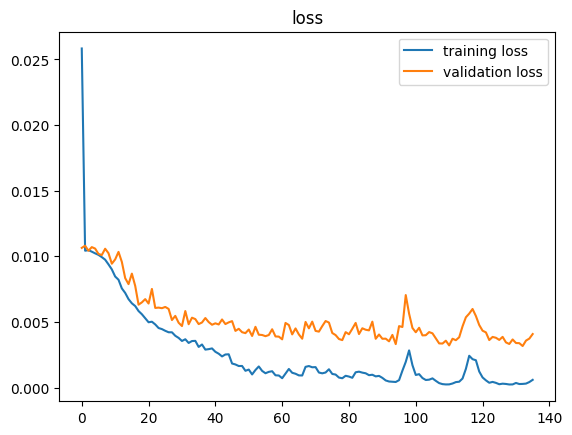

In [47]:
import matplotlib.pyplot as plt


plt.plot(tra_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
#plt.ylim(0,0.02)
plt.title('loss')
plt.legend()

## **Test 資料並儲存成.txt與.png**

In [31]:

import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.

model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, 101)

model_best = model.to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_{myseed}_best.ckpt"))
model_best.eval()


total_y_true = []
total_predi = []

#516/4=129

for p in tqdm(range(129)):
    
    for batch in test_loader:
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.float()
        imgs = imgs.permute(0, 3, 1, 2)
        #imgs = torch.unsqueeze(imgs, dim=0)  # 在第0维上增加一个维度
        
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            test_pred = model_best(imgs.to(device))
    total_y_true.append(labels.cpu())
    total_predi.append(test_pred.argmax(dim=-1).cpu())
    p=p+1


#llabels=np.array(['Rh1','Rh10','Rh20','Rh40','Rh80','Rh160'])   
#print(len(np.concatenate(total_y_true)))
#print(len(np.concatenate(total_predi)))


  0%|          | 0/129 [00:00<?, ?it/s]

In [34]:

import numpy as np

# 將 pp 和 aa 轉換成 numpy array
true_array = np.concatenate(total_y_true)
predi_array = np.concatenate(total_predi)

# 儲存到文本檔案
np.savetxt(f'{_exp_name}_{myseed}.txt', np.column_stack((true_array, predi_array)), delimiter=',', header='true,predi', comments='')

print(f"Data has been saved to {_exp_name}_{myseed}.txt.")


Data has been saved to pre_semi_spin_1215.txt.


In [ ]:
#print(np.concatenate(total_predi))

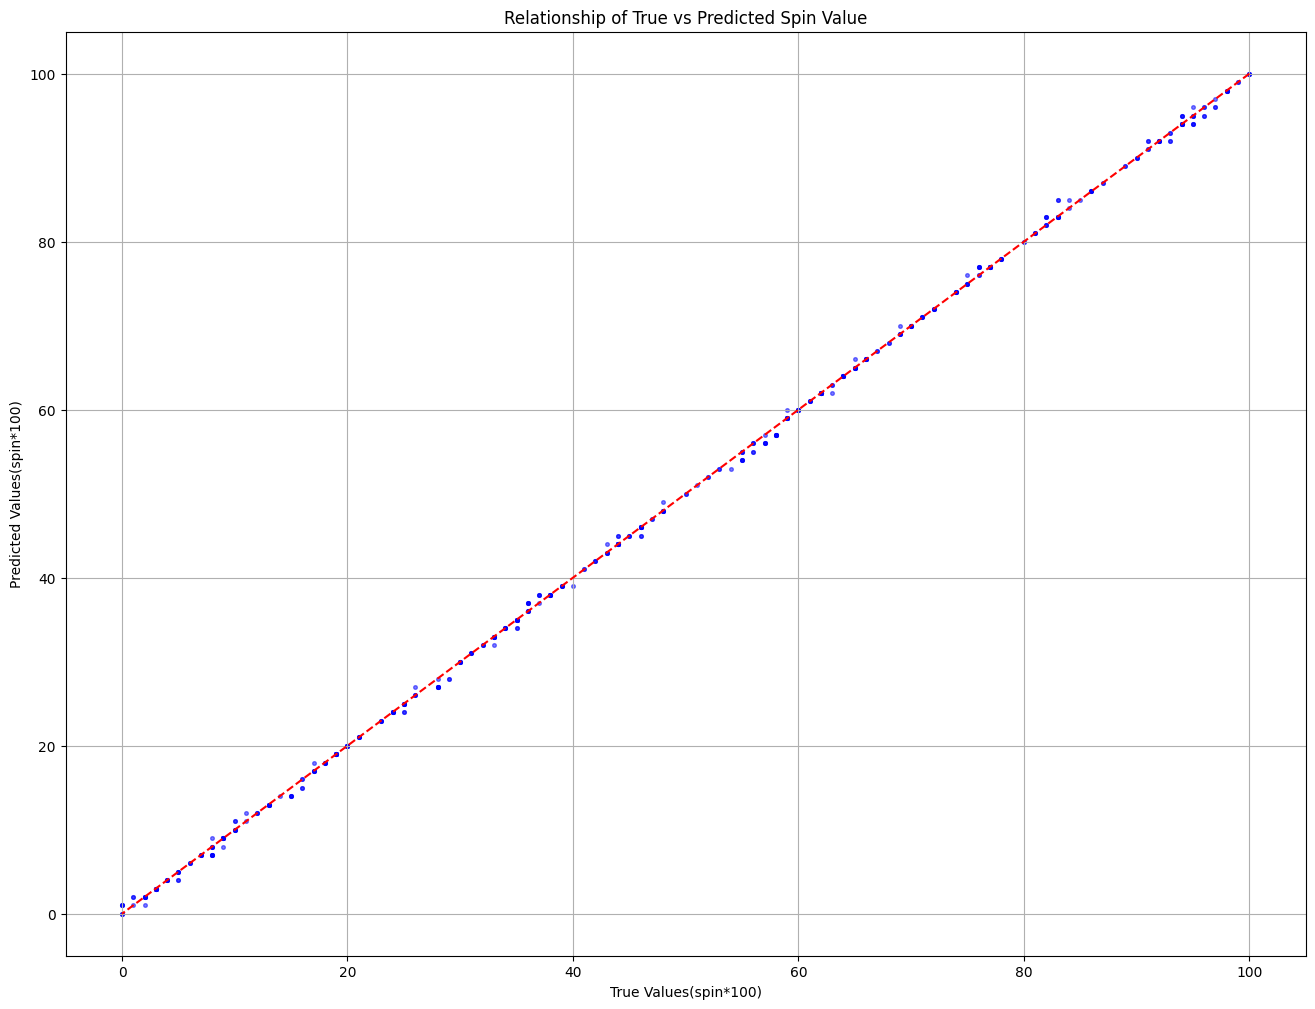

In [32]:
import matplotlib.pyplot as plt


yy_true=np.concatenate(total_y_true)
yy_pre=np.concatenate(total_predi)


plt.figure(figsize=(16, 12))
plt.scatter(yy_true,yy_pre, marker='o', color='blue',s=7, alpha=0.5)
plt.plot([max(yy_true), min(yy_true)], [max(yy_true), min(yy_true)], linestyle='--', color='red')  # 將對角線畫出，作為參考
plt.xlabel('True Values(spin*100)')
plt.ylabel('Predicted Values(spin*100)')
plt.title('Relationship of True vs Predicted Spin Value')
plt.grid(True)
plt.savefig(f"Distribution_{_exp_name}_{myseed}.png")
plt.show()

In [33]:
print(len(yy_true))

516
